<a href="https://colab.research.google.com/github/igorgad/covid-ts-it/blob/master/Multi-Head%20Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoVID19 Time Series Modeling - Multi Head Attention

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv
!wget https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json
!wget https://covid.saude.gov.br/assets/files/COVID19_20200402.csv

!pip install keras-multi-head

--2020-04-23 17:18:03--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78271 (76K) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv’

time_series_covid19 100%[===================>]  76.44K  --.-KB/s    in 0.03s   

2020-04-23 17:18:03 (2.60 MB/s) - ‘time_series_covid19_confirmed_global.csv’ saved [78271/78271]

--2020-04-23 17:18:06--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ..

# Loading Data


In [ ]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
# Replace unkown province/state with the country name
df['Province/State'] = df['Country/Region'] + '-' + df['Province/State']
df.fillna({'Province/State': df['Country/Region']}, inplace=True)
sdf = df.iloc[:, 4:].T.astype(np.float32)
sdf.columns = df['Province/State']
sdf.index = pd.DatetimeIndex(sdf.index)
sdf.head()

Province/State,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia-Australian Capital Territory,Australia-New South Wales,Australia-Northern Territory,Australia-Queensland,Australia-South Australia,Australia-Tasmania,Australia-Victoria,Australia-Western Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cabo Verde,Cambodia,Cameroon,Canada-Alberta,Canada-British Columbia,Canada-Grand Princess,Canada-Manitoba,Canada-New Brunswick,...,Uruguay,US,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe,Canada-Diamond Princess,Dominica,Grenada,Mozambique,Syria,Timor-Leste,Belize,Canada-Recovered,Laos,Libya,West Bank and Gaza,Guinea-Bissau,Mali,Saint Kitts and Nevis,Canada-Northwest Territories,Canada-Yukon,Kosovo,Burma,United Kingdom-Anguilla,United Kingdom-British Virgin Islands,United Kingdom-Turks and Caicos Islands,MS Zaandam,Botswana,Burundi,Sierra Leone,"Netherlands-Bonaire, Sint Eustatius and Saba",Malawi,United Kingdom-Falkland Islands (Malvinas),France-Saint Pierre and Miquelon,South Sudan,Western Sahara,Sao Tome and Principe,Yemen
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fixing WHO Hubei data according to the paper

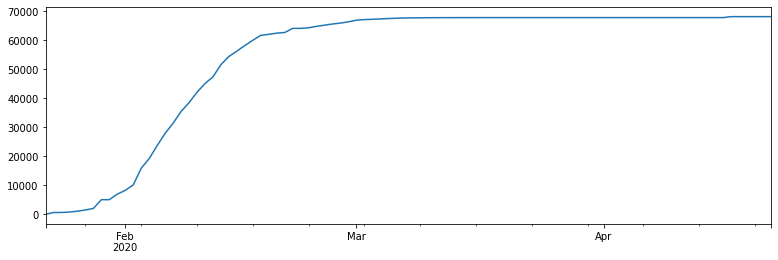

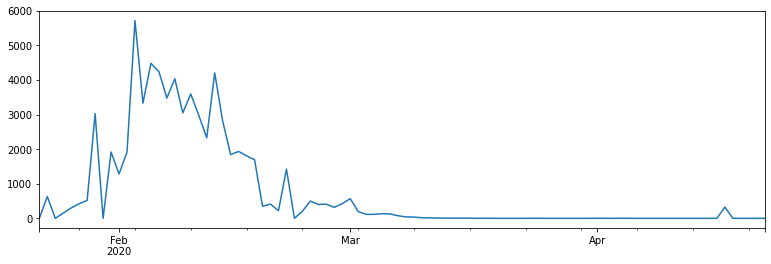

In [ ]:
def fix_hubei_data(sub_data):
    index = np.where(sub_data.index == '2020-02-12')[0][0] + 1
    # Shift data one day to the future
    sub_data.iloc[:index] = np.concatenate([np.zeros([1,]), sub_data.iloc[:index-1].values])

    # Apply parameter to normalize lab tested cases and clinical + lab tested cases
    sub_data.iloc[:index] = sub_data.iloc[:index] * (1 + 15384 / 36602)
    sub_data.iloc[index] = sub_data.iloc[index] * (0.65 + 15384 / 36602)

    return sub_data

# Fix Hubei data
if 'China-Hubei' in sdf.columns:
    sdf['China-Hubei'] = fix_hubei_data(sdf['China-Hubei'])

sdf['China-Hubei'].plot(figsize=(13, 4))
plt.figure()
sdf['China-Hubei'].diff().fillna(0).plot(figsize=(13, 4))

## Normalize by day of first case

In [ ]:
# Normalize data by the day of the first case
date_index = pd.DatetimeIndex(sdf.index)
day_of_first_case = sdf.ne(0).idxmax()
shifts = []
for region in sdf.columns:
    shift_index = np.where(sdf.index == day_of_first_case[region])[0][0]
    sdf[region] = sdf[region].shift(-1 * shift_index, fill_value=np.nan) #sdf[region][-1])
    shifts.append(shift_index)

sdf.index = np.arange(len(sdf.index))
shifts_df = pd.DataFrame(np.expand_dims(np.array(shifts), 0), columns=sdf.columns)
day_of_first_case

Province/State
Afghanistan                        2020-02-24
Albania                            2020-03-09
Algeria                            2020-02-25
Andorra                            2020-03-02
Angola                             2020-03-20
                                      ...    
France-Saint Pierre and Miquelon   2020-04-05
South Sudan                        2020-04-05
Western Sahara                     2020-04-05
Sao Tome and Principe              2020-04-06
Yemen                              2020-04-10
Length: 264, dtype: datetime64[ns]

## Plot some data

In [ ]:
all_regions = sdf.columns
print ('List of available countries or regions: ' + str(all_regions))
sdf

List of available countries or regions: Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia-Australian Capital Territory', 'Australia-New South Wales',
       ...
       'Burundi', 'Sierra Leone',
       'Netherlands-Bonaire, Sint Eustatius and Saba', 'Malawi',
       'United Kingdom-Falkland Islands (Malvinas)',
       'France-Saint Pierre and Miquelon', 'South Sudan', 'Western Sahara',
       'Sao Tome and Principe', 'Yemen'],
      dtype='object', name='Province/State', length=264)


Province/State,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia-Australian Capital Territory,Australia-New South Wales,Australia-Northern Territory,Australia-Queensland,Australia-South Australia,Australia-Tasmania,Australia-Victoria,Australia-Western Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cabo Verde,Cambodia,Cameroon,Canada-Alberta,Canada-British Columbia,Canada-Grand Princess,Canada-Manitoba,Canada-New Brunswick,...,Uruguay,US,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe,Canada-Diamond Princess,Dominica,Grenada,Mozambique,Syria,Timor-Leste,Belize,Canada-Recovered,Laos,Libya,West Bank and Gaza,Guinea-Bissau,Mali,Saint Kitts and Nevis,Canada-Northwest Territories,Canada-Yukon,Kosovo,Burma,United Kingdom-Anguilla,United Kingdom-British Virgin Islands,United Kingdom-Turks and Caicos Islands,MS Zaandam,Botswana,Burundi,Sierra Leone,"Netherlands-Bonaire, Sint Eustatius and Saba",Malawi,United Kingdom-Falkland Islands (Malvinas),France-Saint Pierre and Miquelon,South Sudan,Western Sahara,Sao Tome and Principe,Yemen
0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,1.0,...,4.0,1.0,1.0,2.0,2.0,2.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,4.0,2.0,2.0,2.0,1.0,3.0,71.0,8.0,2.0,2.0,4.0,2.0,3.0,2.0,1.0,2.0,3.0,1.0,1.0,1.0,4.0,4.0,1.0
1,1.0,10.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,4.0,1.0,3.0,2.0,1.0,1.0,2.0,2.0,3.0,1.0,23.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,4.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0,4.0,1.0,...,4.0,1.0,6.0,10.0,2.0,2.0,3.0,-1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,7.0,2.0,4.0,2.0,1.0,3.0,86.0,8.0,2.0,2.0,4.0,2.0,4.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,4.0,4.0,1.0
2,1.0,12.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,4.0,0.0,2.0,2.0,1.0,1.0,2.0,3.0,3.0,1.0,33.0,3.0,5.0,1.0,1.0,2.0,1.0,3.0,3.0,1.0,11.0,4.0,2.0,3.0,1.0,2.0,4.0,1.0,2.0,4.0,1.0,...,8.0,2.0,10.0,17.0,2.0,2.0,3.0,-1.0,2.0,1.0,3.0,1.0,1.0,2.0,0.0,6.0,1.0,16.0,2.0,11.0,2.0,1.0,4.0,91.0,10.0,2.0,2.0,5.0,2.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,4.0,4.0,1.0
3,1.0,23.0,1.0,1.0,3.0,1.0,2.0,1.0,2.0,4.0,0.0,3.0,2.0,1.0,1.0,2.0,3.0,3.0,3.0,33.0,3.0,5.0,1.0,1.0,2.0,1.0,10.0,3.0,2.0,11.0,7.0,2.0,3.0,1.0,2.0,7.0,1.0,2.0,7.0,1.0,...,29.0,2.0,15.0,33.0,2.0,2.0,3.0,-1.0,7.0,1.0,5.0,5.0,1.0,2.0,0.0,6.0,1.0,16.0,2.0,18.0,2.0,1.0,4.0,94.0,14.0,2.0,3.0,5.0,2.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,4.0,4.0,1.0
4,1.0,33.0,1.0,1.0,3.0,1.0,8.0,1.0,2.0,4.0,0.0,2.0,2.0,1.0,2.0,2.0,9.0,6.0,3.0,36.0,3.0,6.0,1.0,1.0,2.0,1.0,10.0,3.0,2.0,37.0,7.0,2.0,3.0,1.0,2.0,7.0,1.0,8.0,8.0,2.0,...,50.0,5.0,23.0,36.0,2.0,3.0,3.0,-1.0,11.0,7.0,7.0,5.0,1.0,2.0,0.0,8.0,3.0,19.0,2.0,18.0,2.0,1.0,4.0,94.0,15.0,2.0,3.0,6.0,9.0,4.0,3.0,4.0,2.0,5.0,5.0,1.0,3.0,4.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2926.0,NaN,NaN,NaN,NaN,1319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,732197.0,NaN,NaN,268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,758809.0,NaN,NaN,268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Total number of places (Province/State/Country/Region): 5


Province/State
China-Hubei   2020-01-23
Italy         2020-01-31
Brazil        2020-02-26
dtype: datetime64[ns]

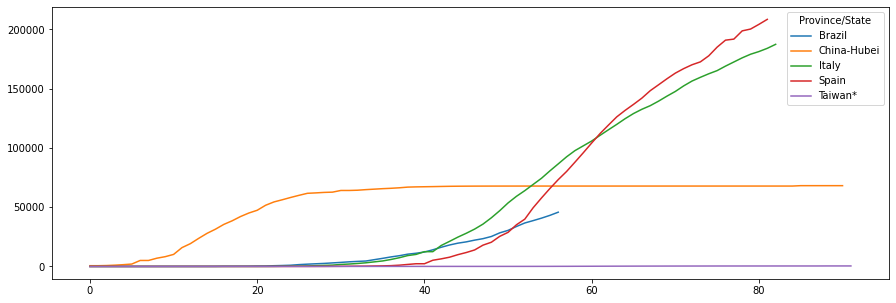

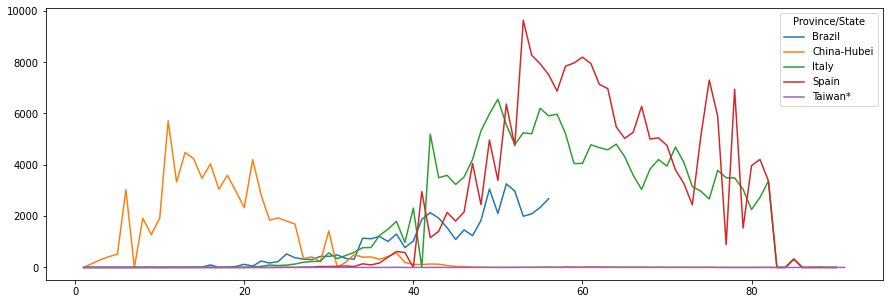

In [ ]:
# Select which countries/regions to use on the dataset
selected_regions = ['China-Hubei', 'Taiwan*', 'Italy', 'Brazil', 'Spain']
rdf = sdf.loc[:, sdf.columns.str.contains(r'|'.join(selected_regions))]

print('Total number of places (Province/State/Country/Region): ' + str(len(rdf.columns)))
rdf.plot(figsize=(15, 5))
rdf.diff().fillna(axis=1, method='ffill').plot(figsize=(15, 5))
day_of_first_case.loc[['China-Hubei', 'Italy', 'Brazil']]

## Data Preprocessing

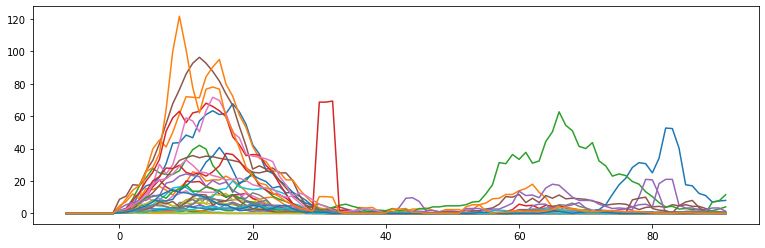

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def get_data(df, regions=['China'], pad_start=None, pad_end=None, normalize=None, average_size=1):
    # Select which countries/regions to use on the dataset
    if regions:
        data = df.loc[:, df.columns.str.contains(r'|'.join(regions))]
    else:
        data = df

    if pad_start:
        # Pad the Begging and End of data
        beg_index = -1 * np.arange(pad_start, 0, -1)
        beg_zero_df = pd.DataFrame(np.zeros([len(beg_index), len(data.columns)]),
                        columns=data.columns,
                        index=beg_index)
        data = pd.concat([beg_zero_df, data], axis=0)
        
    if pad_end:
        end_index = np.arange(data.index[-1], data.index[-1] + pad_end)
        end_zero_df = pd.DataFrame(np.nan * np.ones([len(end_index), len(data.columns)]),
                        columns=data.columns,
                        index=end_index)
        
        data = pd.concat([data, end_zero_df], axis=0)

    # Differentiate to obtain daily cases
    # data = data.diff(axis=0).astype(np.float32)
    # data = data.diff(axis=0).fillna(0.0).astype(np.float32)
    data = data.diff(axis=0).fillna(data).astype(np.float32)
    # data = data.diff(axis=0).fillna(data).astype(np.float32)

    # Moving Average
    data = data.rolling(average_size, min_periods=1).mean() #.fillna(data)
    
    # Normalizing
    scaler = None
    if normalize == 'MinMax':
        scaler = MinMaxScaler()
        data[data.columns] = scaler.fit_transform(data[data.columns])
    if normalize == 'Standard':
        scaler = StandardScaler()
        data[data.columns] = scaler.fit_transform(data[data.columns])

    return data, scaler

data, _ = get_data(sdf, regions=['China'], pad_start=8, normalize=None, average_size=3)
data.loc[:, data.columns != 'China-Hubei'].fillna(0.0).plot(figsize=(13, 4), legend=False)

# Multi Head Attention

## Sequences Generation

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

class MAEtsGenerator(TimeseriesGenerator):
    def __init__(self, *args, **kwargs):
        self.norm = kwargs.pop('normalization')
        super(MAEtsGenerator, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        samples, targets = super().__getitem__(index)
        samples = np.reshape(np.transpose(samples, [0, 2, 1]), [-1, self.length])
        targets = np.reshape(np.expand_dims(targets, -1), [-1, 1])

        # Normalizing
        if self.norm == 'Standard':
            S = samples.std(axis=1, keepdims=True)
            M = samples.mean(axis=1, keepdims=True)
            samples = np.divide(samples - M, S, out=np.zeros_like(samples), where=S!=0)
            targets = np.divide(targets - M, S, out=np.zeros_like(targets), where=S!=0)

        if self.norm == 'DivMean':
            M = samples.mean(axis=1, keepdims=True)
            samples = np.divide(samples, M, out=np.zeros_like(samples), where=M!=0)
            targets = np.divide(targets, M, out=np.zeros_like(targets), where=M!=0)
        
        if self.norm == 'MinMax':
            max = samples.max(axis=1, keepdims=True)
            min = samples.min(axis=1, keepdims=True)
            minmaxdiff = max - min
            samples = np.divide(samples - min, minmaxdiff, out=np.zeros_like(samples), where=minmaxdiff!=0)
            targets = np.divide(targets - min, minmaxdiff, out=np.zeros_like(targets), where=minmaxdiff!=0)
        return samples, targets

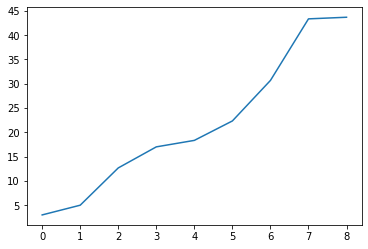

In [ ]:
def get_sequence_generator(data, normalization='divmean', length=8, shuffle=True, batch_size=1):
    generator = MAEtsGenerator(data.values, data.values, length=length, batch_size=batch_size, normalization=normalization, shuffle=shuffle)
    return generator

generator = get_sequence_generator(data, normalization='divmean', shuffle=False)
train_exs = 0
for i, (x, y) in enumerate(generator):
    train_exs += 1

x, y = generator[9]
plt.plot(np.concatenate([x[0,:], y[0]]))

## Training Loop

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


def train(models, train_generator, eval_generator, lr=1e-3, epochs=100, d_model=None):
    if d_model:
        lr = CustomSchedule(d_model)

    def train_model(model):
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=0),
            # tf.keras.callbacks.ModelCheckpoint(workspace + '/Checkpoints/MAE', monitor='val_loss', save_best_only=True, verbose=0)
        ]

        model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9), 
                      loss='mean_squared_error')


        trace = model.fit(train_generator, epochs=epochs, validation_data=eval_generator, callbacks=callbacks, verbose=0)
        # tf.keras.backend.clear_session()
        return trace
    return [train_model(model) for model in models]

## Evaluation Loop

In [ ]:
def evaluate(models, generator, forecast_start_day=15, normalization='DivMean'):
    xi, yi = generator[0]

    predicted_values = np.zeros([xi.shape[0], 0])
    true_values = np.zeros([xi.shape[0], 0])

    # Iterate over a set with support data
    for i, (ex, y) in enumerate(generator):
        if i < forecast_start_day:
            x = ex
        # Normalize
        if normalization == 'Standard':
            S = x.std(axis=1, keepdims=True)
            M = x.mean(axis=1, keepdims=True)
            x = np.divide(x - M, S, out=np.zeros_like(x), where=S!=0)
        if normalization == 'DivMean':
            # M = np.concatenate([x, y], axis=1).mean(axis=1, keepdims=True)
            M = x.mean(axis=1, keepdims=True)
            x = np.divide(x, M, out=np.zeros_like(x), where=M!=0)
        if normalization == 'MinMax':
            max = x.max(axis=1, keepdims=True)
            min = x.min(axis=1, keepdims=True)
            minmaxdiff = max - min
            x = np.divide(x - min, minmaxdiff, out=np.zeros_like(x), where=minmaxdiff!=0)
        # Predict
        outs = [model.predict(x) for model in models]
        # Average models predictions
        pred = np.array([out for out in outs]).mean(0)
        # Restore
        if normalization == 'Standard':
            pred = pred * S + M
            x = x * S + M
        if normalization == 'DivMean':
            pred = pred * M
            x = x * M
        if normalization == 'MinMax':
            pred = pred * minmaxdiff + min
            x = x * minmaxdiff + min
        # Append
        predicted_values = np.concatenate([predicted_values, pred], axis=1)
        true_values = np.concatenate([true_values, y], axis=1)
        # Shift
        x = np.concatenate([x, pred], axis=1)[:, 1:]        

    return predicted_values.T, true_values.T

## Multi Head Attention Layers

### Positional Encoding Layer

In [ ]:

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], 
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

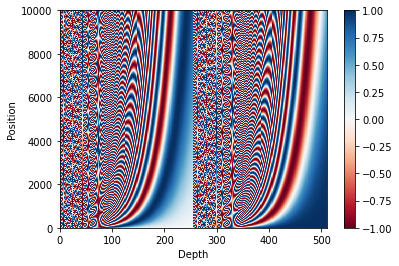

In [ ]:
sample_pos_encoding = PositionalEncoding(10000, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Attention Layer

In [ ]:
a = tf.ones((1, 16, 8))
a = tf.reshape(a, (1, -1, 4, 2))
a = tf.transpose(a, [0, 2, 1, 3])
b = tf.shape(a)
b.numpy()

array([ 1,  4, 16,  2], dtype=int32)

In [ ]:
def scaled_dot_product_attention(query, key, value):
    matmul_qk = tf.matmul(query, key, transpose_b=True) #(bs, 4, 16, 16)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth) #(bs, 4, 16, 16) - Normalize by squared mean of head depth

    # add the mask zero out padding tokens.
    # if mask is not None:
    #     logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1) # (bs, 4, 16, 16)
    attentioned = tf.matmul(attention_weights, value) # (bs, 4, 16, 16) * (bs, 4, 16, 2) = (bs, 4, 16, 2)
    # attentioned = tf.ensure_shape(attentioned, tf.shape(value))
    return attentioned


class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads # 2 = 8 // 4
        self.query_dense = tf.keras.layers.Dense(units=d_model) # 8
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth)) # (bs, 16, 8) -> (bs,  16, 4, 2)
        return tf.transpose(inputs, perm=[0, 2, 1, 3]) # (bs,  16, 4, 2) -> (bs, 4, 16, 2)

    def call(self, inputs):
        query, key, value = inputs['query'], inputs['key'], inputs['value']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query) # (bs, 16, 8)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size) # (bs, 4, 16, 2)
        key = self.split_heads(key, batch_size) # (bs, 4, 16, 2)
        value = self.split_heads(value, batch_size) # (bs, 4, 16, 2)

        scaled_attention = scaled_dot_product_attention(query, key, value) # (bs, 4, 16, 2)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # (bs, 4, 16, 2) -> (bs, 16, 4, 2)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) # (bs, 16, 8)
        outputs = self.dense(concat_attention) # (bs, 16, 8)
        return outputs

### Encoder Layer

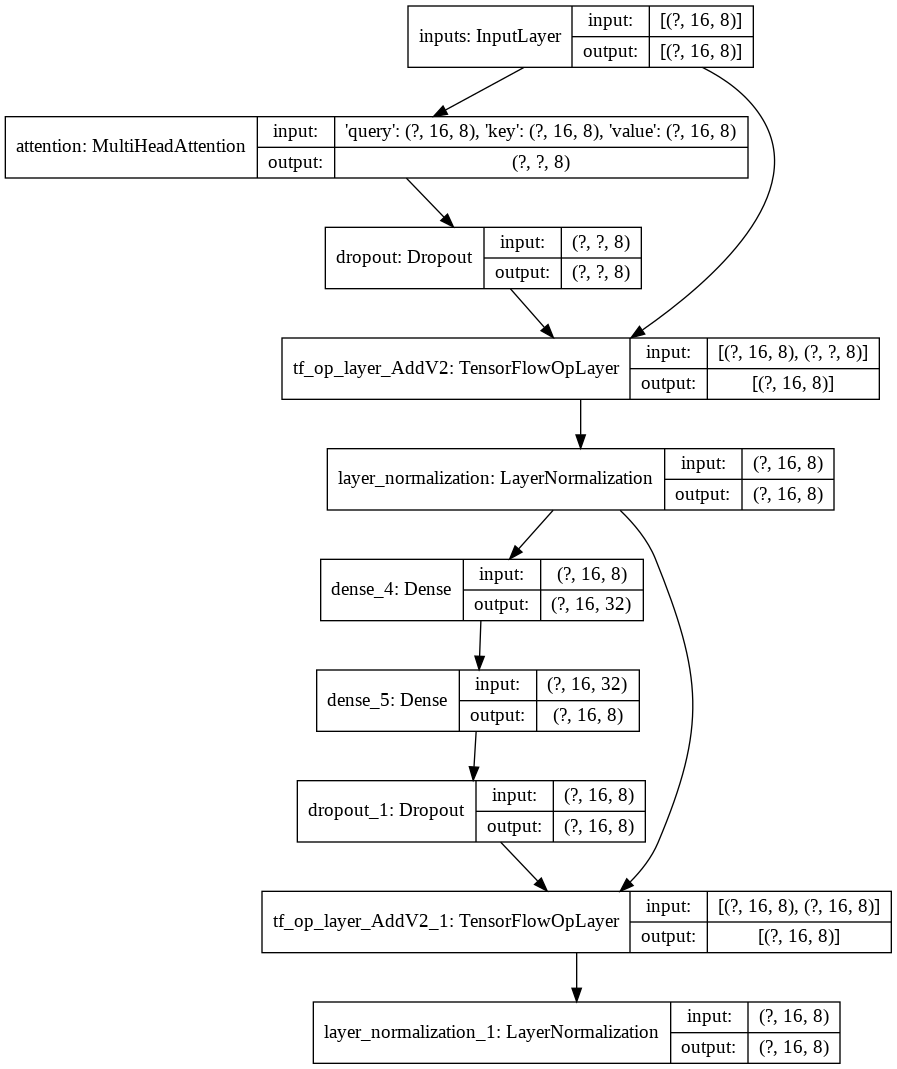

In [ ]:
def encoder_layer(sequence_length, units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(sequence_length, d_model), name="inputs")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs
        })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

sample_encoder_layer = encoder_layer(16, 32, 8, 4, 0.5)
tf.keras.utils.plot_model(sample_encoder_layer, show_shapes=True, show_layer_names=True, to_file='model.png')

## Define Model - Encoder

In [ ]:
# Parameters
train_regions = ['China', 'Taiwan*']
eval_regions = ['Italy']
num_models = 1
data_normalization = 'MinMax' #None
block_normalization = None #'DivMean'
sequence_length = 8
d_model = 256
num_heads = 8
num_layers = 2
units = 512
lr = 1e-3
dropout = 0.1
pad_start = sequence_length
average_size = 3

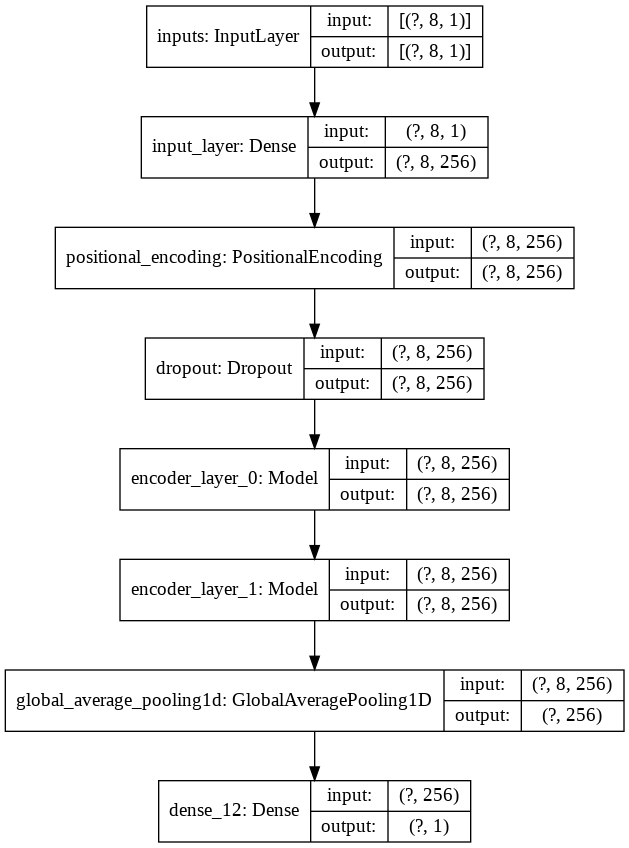

In [ ]:
tf.keras.backend.clear_session()
sd = 5
tf.random.set_seed(sd)
np.random.seed(sd)

def encoder(sequence_length,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(sequence_length, 1), name="inputs")

    encoded_inputs = tf.keras.layers.Dense(d_model, name='input_layer')(inputs)
    encoded_position = PositionalEncoding(10000, d_model)(encoded_inputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(encoded_position)

    for i in range(num_layers):
        outputs = encoder_layer(sequence_length=sequence_length,
                                units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout=dropout,
                                name="encoder_layer_{}".format(i))(outputs)
    
    # Preictor
    # output = tf.keras.layers.Flatten()(outputs)
    output = tf.keras.layers.GlobalAveragePooling1D()(outputs)
    output = tf.keras.layers.Dense(1, activation='linear')(output)

    return tf.keras.Model(inputs=inputs, outputs=output, name=name)


models = [encoder(sequence_length, num_layers, units, d_model, num_heads, dropout) for _ in range(num_models)]
tf.keras.utils.plot_model(models[0], show_shapes=True, show_layer_names=True, to_file='model.png')

### Training

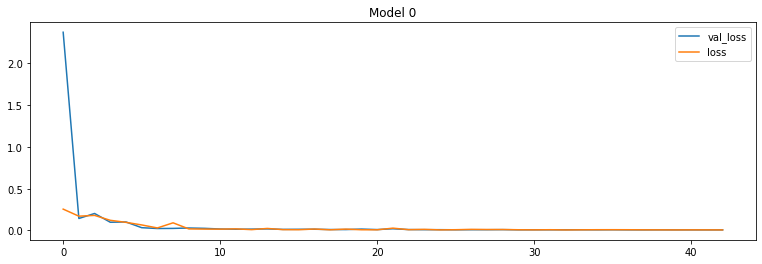

In [ ]:
train_data, _ = get_data(sdf, regions=train_regions, pad_start=pad_start, pad_end=None, normalize=data_normalization, average_size=average_size)
eval_data, _ = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=None, normalize=data_normalization, average_size=average_size)

train_generator = get_sequence_generator(train_data.fillna(0.0), length=sequence_length, normalization=block_normalization, shuffle=False, batch_size=1)
eval_generator = get_sequence_generator(eval_data.fillna(0.0), length=sequence_length, normalization=block_normalization, shuffle=False, batch_size=1)

traces = train(models, train_generator, eval_generator, lr=lr, epochs=100)

for i,trace in enumerate(traces):
    pd.DataFrame(np.stack([trace.history['loss'], 
                           trace.history['val_loss']], axis=1), 
                 columns={'loss', 'val_loss'}).plot(figsize=(13, 4), title='Model %d' % i)


### Forecasting

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.divide(np.abs(y_true - y_pred), y_true, out=np.ones_like(y_true) * np.nan, where=y_true!=0), axis=0) * 100

#### China

                            MAPE      XCOR
Province/State                            
China-Anhui            33.792354  0.994002
China-Beijing          51.458644  0.957527
China-Chongqing        38.117228  0.979124
China-Fujian           52.556255  0.970660
China-Gansu            58.042385  0.885169
China-Guangdong        60.238867  0.991242
China-Guangxi          38.302928  0.961148
China-Guizhou          53.376438  0.955330
China-Hainan           35.138944  0.947710
China-Hebei            60.521860  0.974330
China-Heilongjiang     62.005214  0.533224
China-Henan            46.075844  0.990372
China-Hong Kong       279.028517  0.638130
China-Hubei            93.511354  0.979076
China-Hunan            43.513185  0.994749
China-Inner Mongolia  610.891371  0.427946
China-Jiangsu          44.927188  0.995845
China-Jiangxi          39.614088  0.983566
China-Jilin            58.821248  0.956833
China-Liaoning        470.400592  0.410499
China-Macau            47.475432  0.917964
China-Ningx

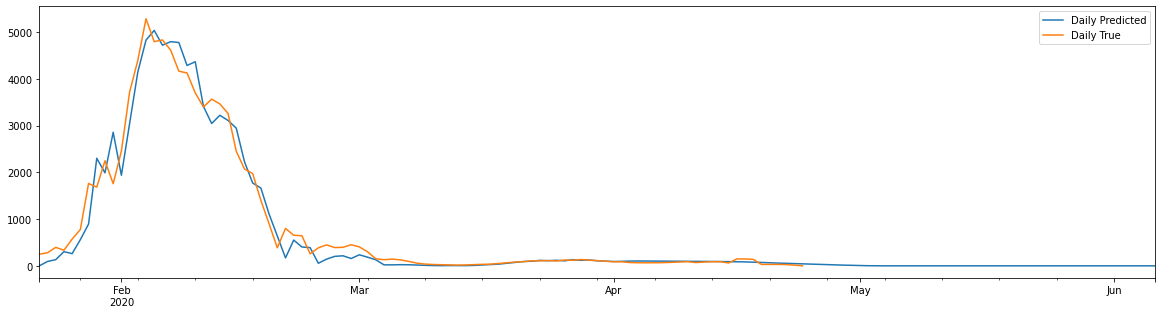

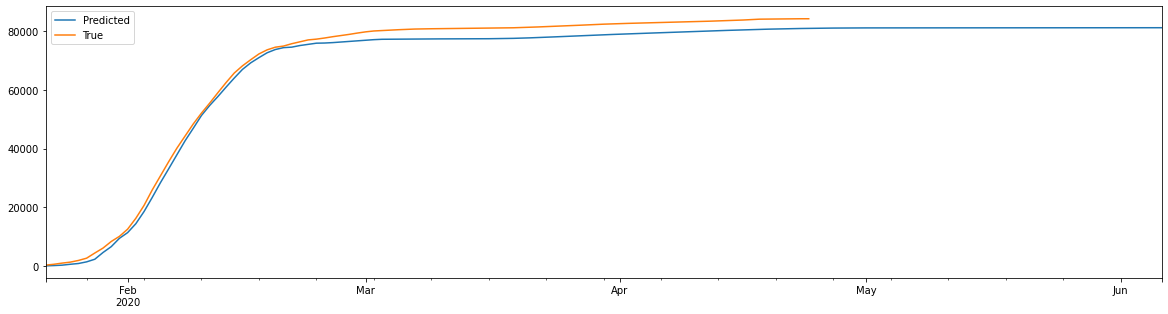

In [ ]:
eval_regions = ['China', 'Taiwan*']
forcast_start_date = '2020-04-01'
# average_size = 3
pad_start = sequence_length
pad_end = 45

min_start_day = day_of_first_case.loc[day_of_first_case.index.str.contains(r'|'.join(eval_regions))].min()
forecast_start_day = (pd.to_datetime(forcast_start_date) - min_start_day).days

eval_data, scaler = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = evaluate(models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### Italy

                    MAPE      XCOR
Province/State                    
Italy           73.73823  0.804916
MAPE    73.738230
XCOR     0.804916
dtype: float64


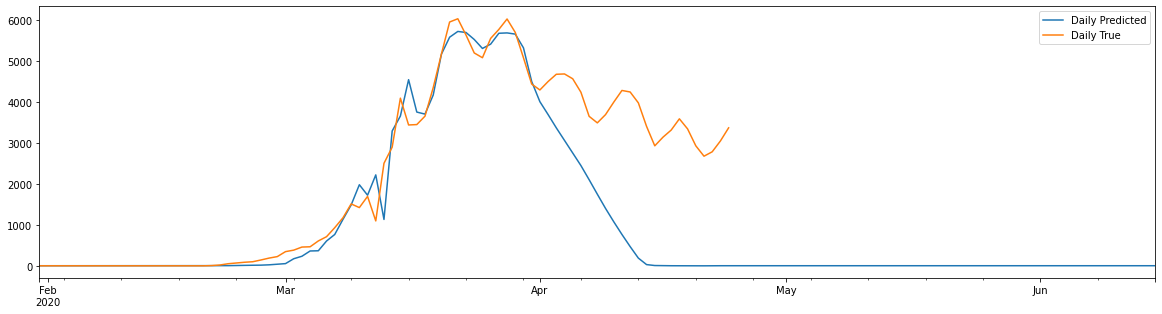

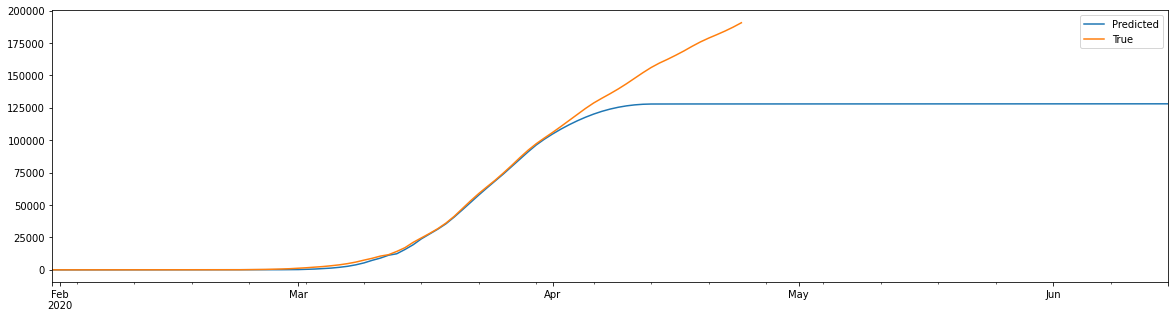

In [ ]:
eval_regions = ['Italy']
forcast_start_date = '2020-04-01'
# average_size = 3
pad_start = sequence_length
pad_end = 45

min_start_day = day_of_first_case.loc[day_of_first_case.index.str.contains(r'|'.join(eval_regions))].min()
forecast_start_day = (pd.to_datetime(forcast_start_date) - min_start_day).days

eval_data, scaler = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = evaluate(models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### Brazil

                     MAPE      XCOR
Province/State                     
Brazil          85.485829 -0.206841
MAPE    85.485829
XCOR    -0.206841
dtype: float64


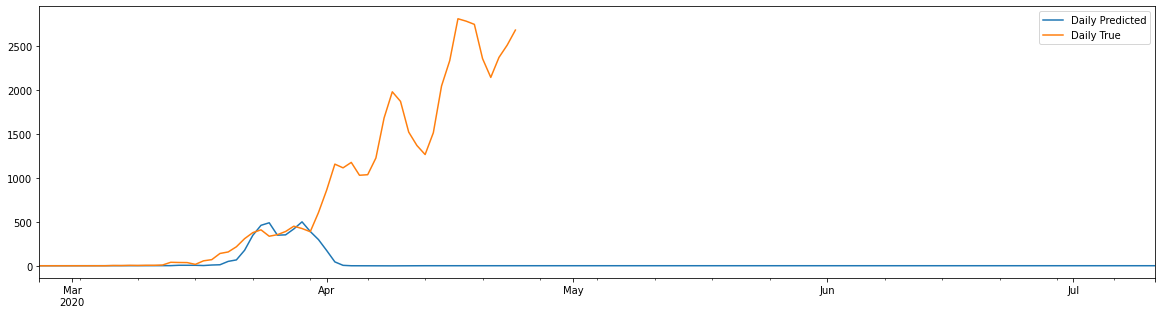

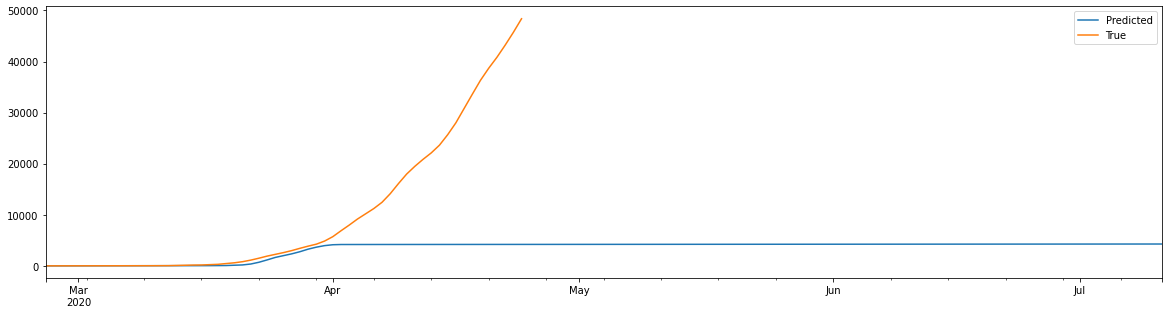

In [ ]:
eval_regions = ['Brazil']
forcast_start_date = '2020-04-01'
# average_size = 3
pad_start = sequence_length
pad_end = 45

min_start_day = day_of_first_case.loc[day_of_first_case.index.str.contains(r'|'.join(eval_regions))].min()
forecast_start_day = (pd.to_datetime(forcast_start_date) - min_start_day).days

eval_data, scaler = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = evaluate(models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### Spain

                      MAPE      XCOR
Province/State                      
Spain           102.743731  0.923221
MAPE    102.743731
XCOR      0.923221
dtype: float64


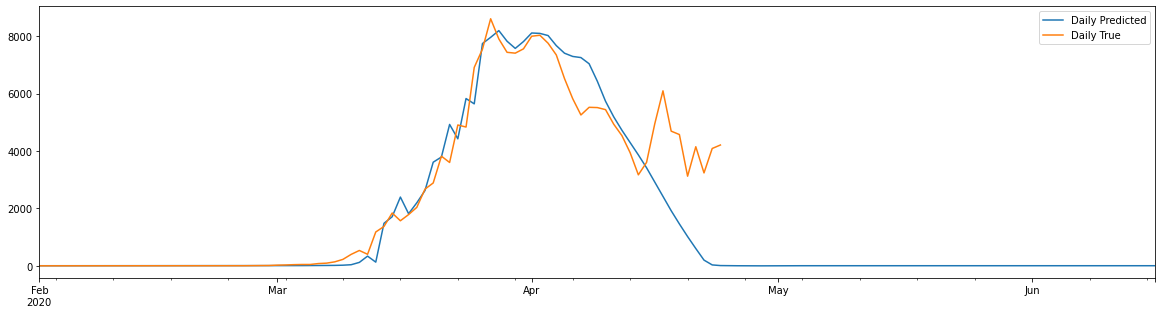

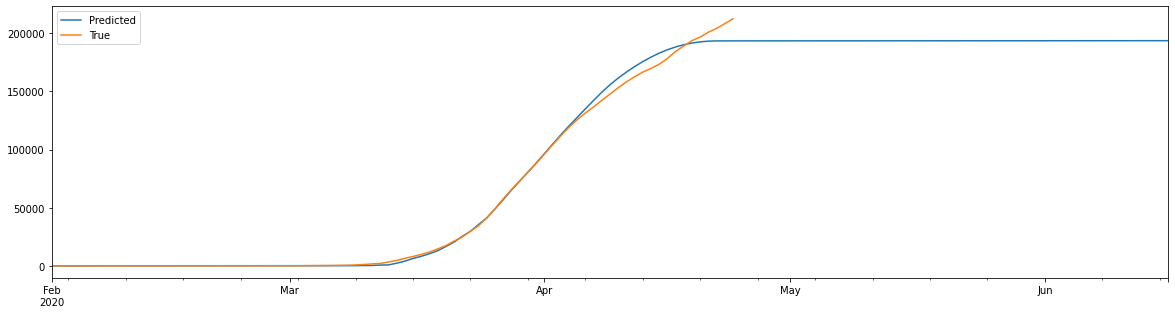

In [ ]:
eval_regions = ['Spain']
forcast_start_date = '2020-04-01'
# average_size = 3
pad_start = sequence_length
pad_end = 45

min_start_day = day_of_first_case.loc[day_of_first_case.index.str.contains(r'|'.join(eval_regions))].min()
forecast_start_day = (pd.to_datetime(forcast_start_date) - min_start_day).days

eval_data, scaler = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = evaluate(models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### UK

                                                 MAPE      XCOR
Province/State                                                 
United Kingdom-Bermuda                      89.582850  0.594326
United Kingdom-Cayman Islands               85.597833  0.742123
United Kingdom-Channel Islands              58.537838  0.894280
United Kingdom-Gibraltar                    51.592951  0.905057
United Kingdom-Isle of Man                  43.692301  0.809165
United Kingdom-Montserrat                   42.318269  0.515559
United Kingdom                              85.208898  0.946335
United Kingdom-Anguilla                     36.146139  0.593477
United Kingdom-British Virgin Islands       33.988524  0.677782
United Kingdom-Turks and Caicos Islands     56.912919  0.527213
United Kingdom-Falkland Islands (Malvinas)  54.496201  0.513994
MAPE    58.006793
XCOR     0.701756
dtype: float64


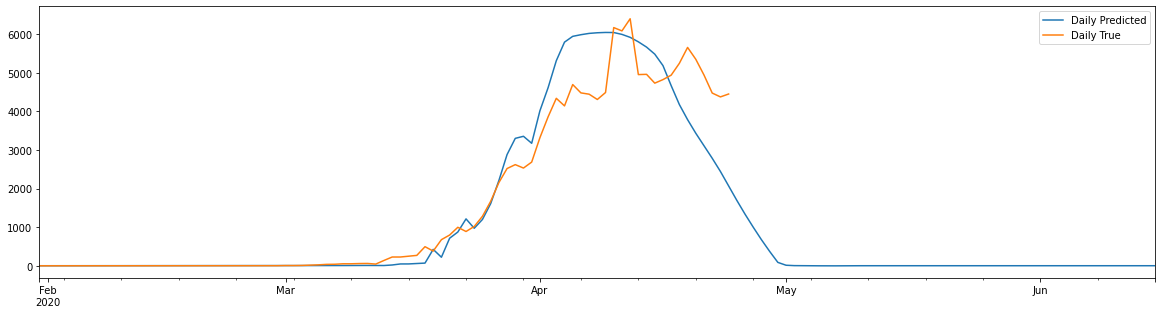

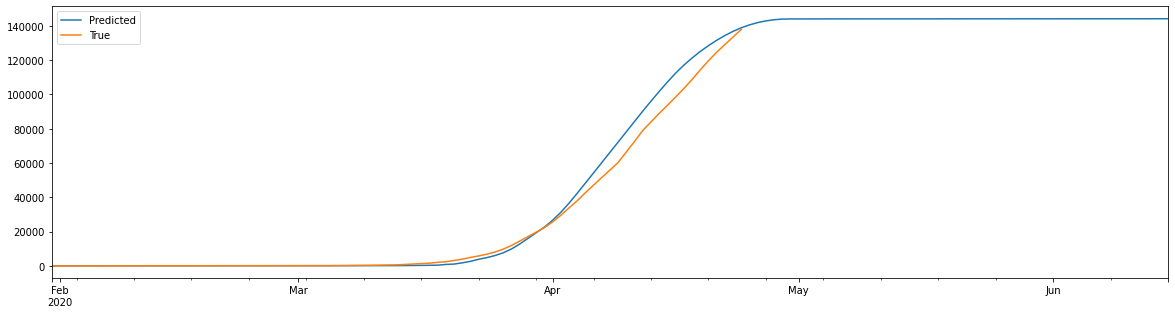

In [ ]:
eval_regions = ['United Kingdom']
forcast_start_date = '2020-04-01'
# average_size = 3
pad_start = sequence_length
pad_end = 45

min_start_day = day_of_first_case.loc[day_of_first_case.index.str.contains(r'|'.join(eval_regions))].min()
forecast_start_day = (pd.to_datetime(forcast_start_date) - min_start_day).days

eval_data, scaler = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = evaluate(models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

pd.DataFrame(np.stack([predicted_df['United Kingdom'].values, trues_df['United Kingdom'].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df['United Kingdom'].cumsum().values, trues_df['United Kingdom'].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### US

                      MAPE      XCOR
Province/State                      
US              497.306034  0.930275
MAPE    497.306034
XCOR      0.930275
dtype: float64


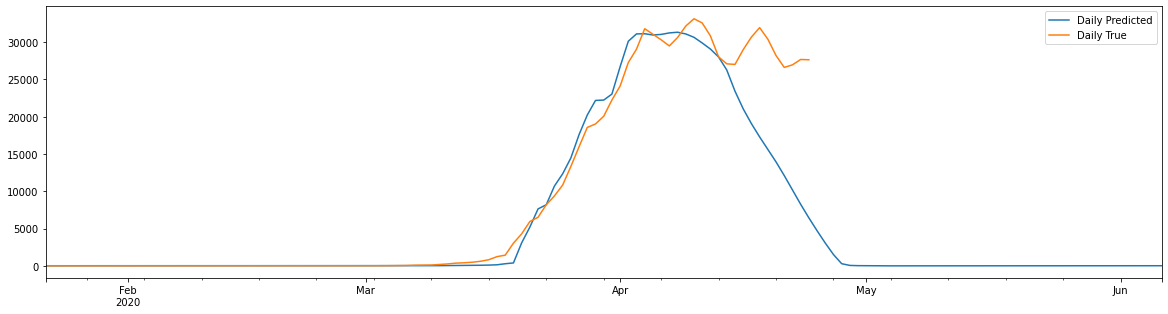

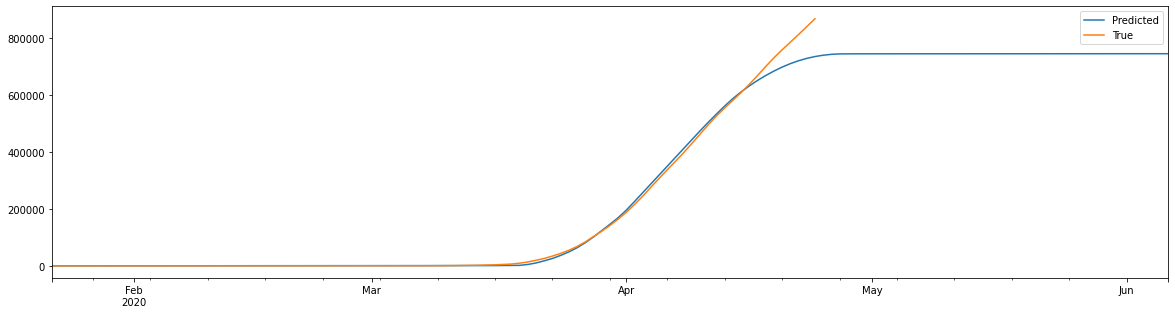

In [ ]:
eval_regions = ['US']
forcast_start_date = '2020-04-01'
# average_size = 3
pad_start = sequence_length
pad_end = 45

min_start_day = day_of_first_case.loc[day_of_first_case.index.str.contains(r'|'.join(eval_regions))].min()
forecast_start_day = (pd.to_datetime(forcast_start_date) - min_start_day).days

eval_data, scaler = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = evaluate(models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### France

                                          MAPE      XCOR
Province/State                                          
France-French Guiana                 80.669718  0.631250
France-French Polynesia              66.491764  0.687001
France-Guadeloupe                    45.988715  0.862197
France-Mayotte                       50.961919  0.757408
France-New Caledonia                 76.272398  0.807288
France-Reunion                       48.787309  0.909421
France-Saint Barthelemy              29.403233  0.669485
France-St Martin                     47.514743  0.772047
France-Martinique                    63.334020  0.821544
France                            22758.131652  0.836260
France-Saint Pierre and Miquelon     37.458683  0.609130
MAPE    2118.637650
XCOR       0.760275
dtype: float64


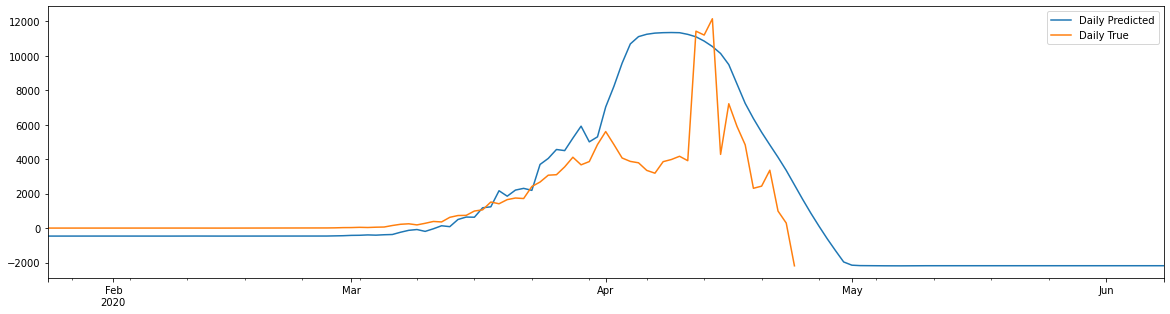

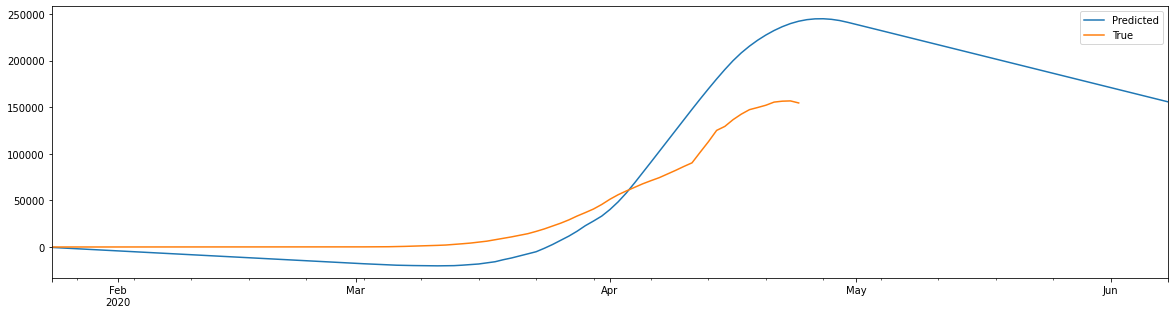

In [ ]:
eval_regions = ['France']
forcast_start_date = '2020-04-01'
# average_size = 3
pad_start = sequence_length
pad_end = 45

min_start_day = day_of_first_case.loc[day_of_first_case.index.str.contains(r'|'.join(eval_regions))].min()
forecast_start_day = (pd.to_datetime(forcast_start_date) - min_start_day).days

eval_data, scaler = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = evaluate(models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

pd.DataFrame(np.stack([predicted_df['France'].values, trues_df['France'].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df['France'].cumsum().values, trues_df['France'].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

### Italy - Mimmo Data

In [ ]:
forecast_start_date = '2020-04-01'
average_size = 3
pad_start = sequence_length
pad_end = 60

#### Data Preprocessing

(60, 21)


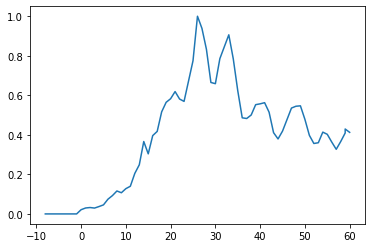

In [ ]:
ddf = pd.read_json('dpc-covid19-ita-regioni.json')
posdf = ddf[['denominazione_regione', 'lat', 'long']].drop_duplicates()
regions = ddf.denominazione_regione.unique()
ddf.data = pd.to_datetime(ddf.data)
ddf.set_index(ddf.data)
dates = ddf.data.unique()


mdf = pd.DataFrame(index=np.arange(len(dates)), columns=regions)
for region in regions:
    mdf[region] = ddf[ddf.denominazione_regione == region]['nuovi_positivi'].cumsum().values

print(mdf.shape)
eval_data, scaler = get_data(mdf, regions=None, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
eval_data['Lombardia'].plot()

#### Forecasting

In [ ]:
forecast_start_day = (pd.to_datetime(forcast_start_date) - dates[0]).days
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = evaluate(models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=dates[0], periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=dates[0], periods=preds.shape[0]))

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

                             MAPE      XCOR
Abruzzo                 53.847007  0.737735
Basilicata              79.064378  0.844660
P.A. Bolzano            43.398629  0.894027
Calabria                82.783916  0.766589
Campania                44.696473  0.904388
Emilia-Romagna          41.483883  0.858569
Friuli Venezia Giulia   54.084149  0.800432
Lazio                   40.287132  0.872405
Liguria                134.269420  0.595836
Lombardia               44.567198  0.797489
Marche                  50.280109  0.841538
Molise                 242.886618  0.348961
Piemonte                39.893452  0.809300
Puglia                  38.152547  0.815387
Sardegna                49.835674  0.888187
Sicilia                 51.590857  0.859907
Toscana                 38.588449  0.907641
P.A. Trento             60.137589  0.606256
Umbria                 449.356611  0.581389
Valle d'Aosta           66.972008  0.781387
Veneto                  47.176888  0.720122
MAPE    83.492999
XCOR     0.772

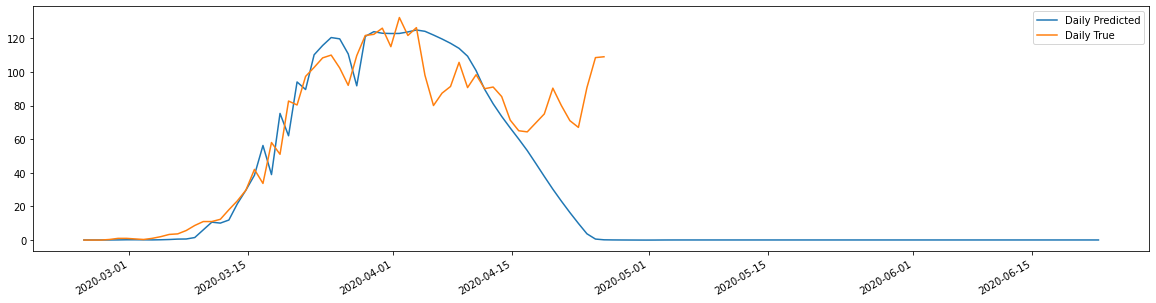

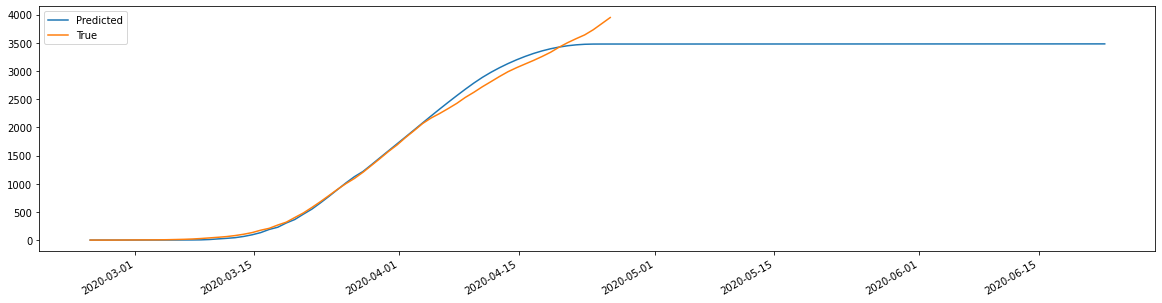

In [ ]:
region = 'Puglia'
pd.DataFrame(np.stack([predicted_df[region].values, trues_df[region].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df[region].cumsum().values, trues_df[region].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

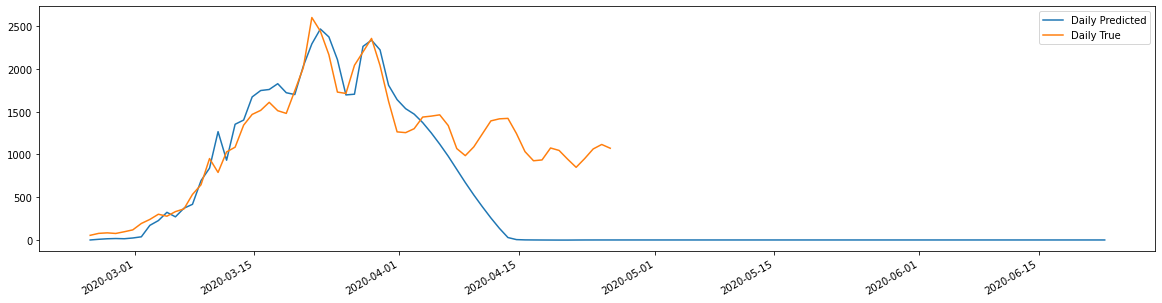

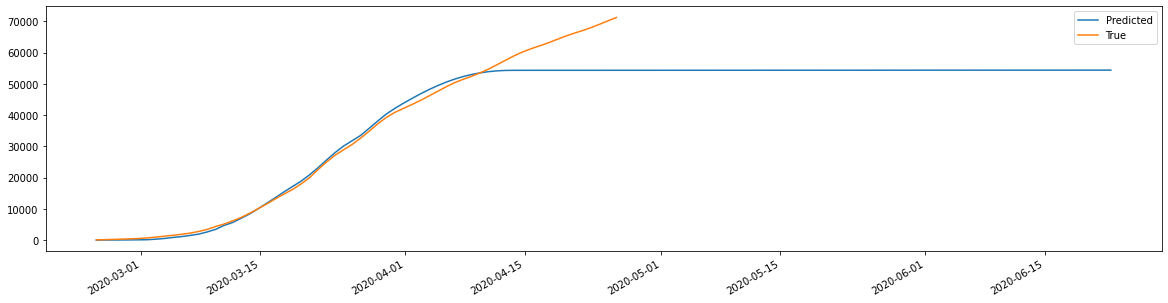

In [ ]:
region = 'Lombardia'
pd.DataFrame(np.stack([predicted_df[region].values, trues_df[region].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df[region].cumsum().values, trues_df[region].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

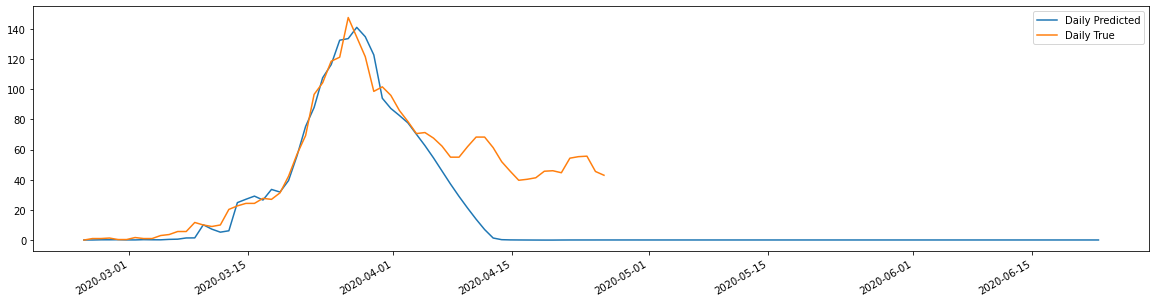

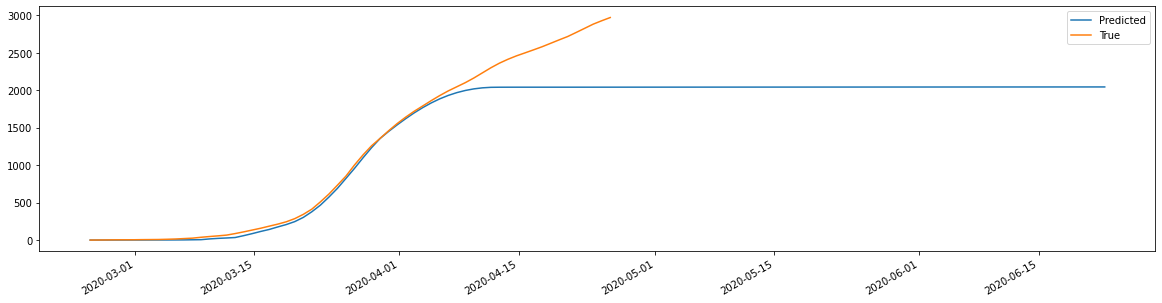

In [ ]:
region = 'Sicilia'
pd.DataFrame(np.stack([predicted_df[region].values, trues_df[region].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df[region].cumsum().values, trues_df[region].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

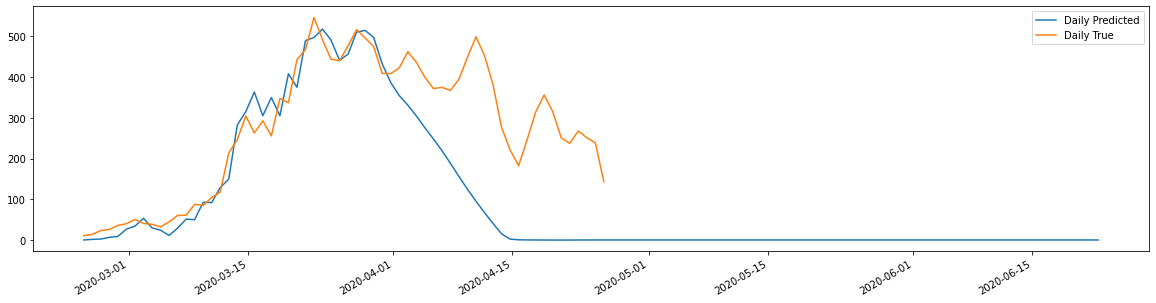

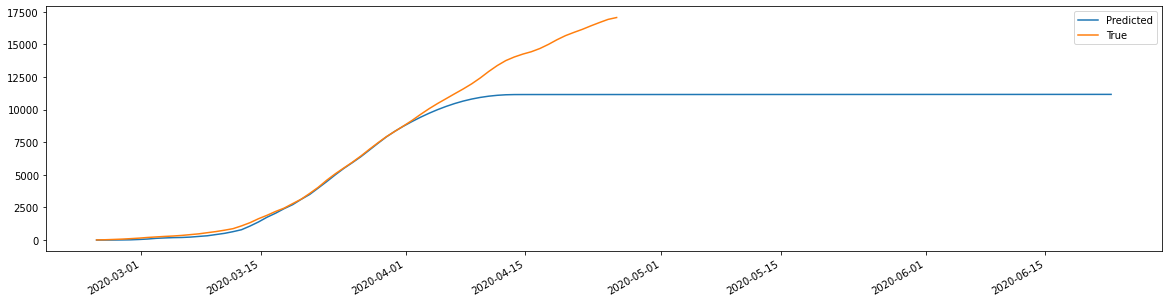

In [ ]:
region = 'Veneto'
pd.DataFrame(np.stack([predicted_df[region].values, trues_df[region].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df[region].cumsum().values, trues_df[region].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

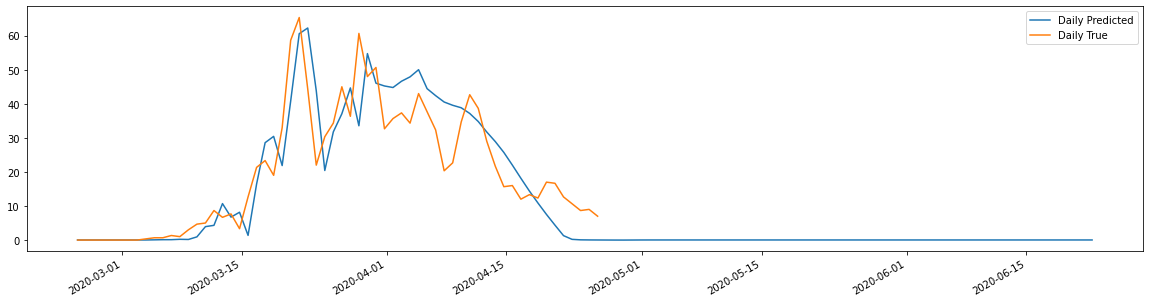

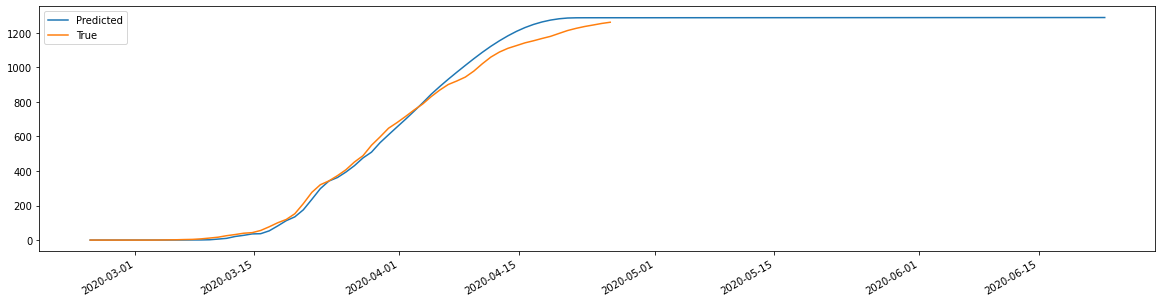

In [ ]:
region = 'Sardegna'
pd.DataFrame(np.stack([predicted_df[region].values, trues_df[region].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df[region].cumsum().values, trues_df[region].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

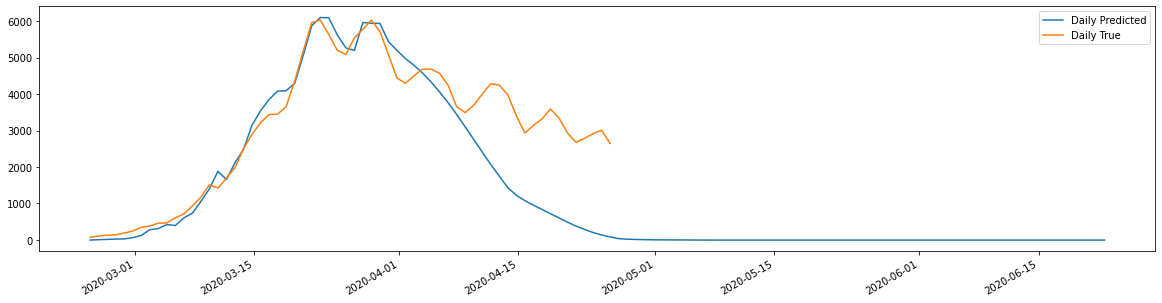

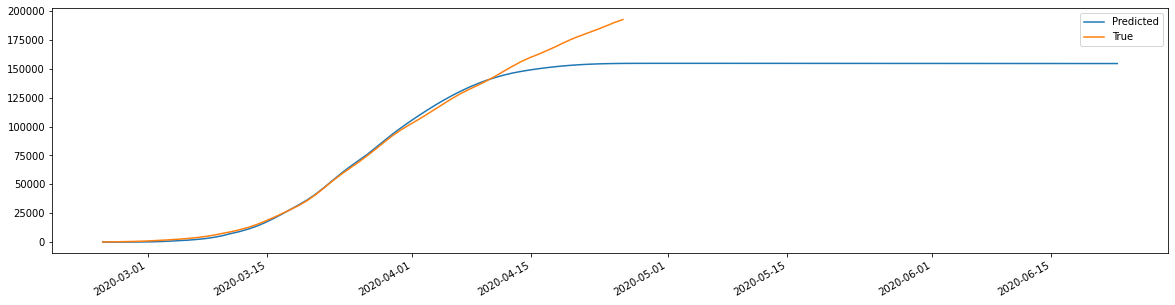

In [ ]:
# Summed of all Italy Cities
pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

#### Save Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
workspace = '/content/drive/My Drive/Colab Notebooks/COVID19'
df_folder = workspace + '/experiments/MHA-avg3-v0/'
predicted_df.to_csv(df_folder + 'predictions.csv')
trues_df.to_csv(df_folder + 'trues.csv')

for i, model in enumerate(models):
    model.save_weights(df_folder + 'models/model%d.h5' % i)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Generate Report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

workspace = '/content/drive/My\ Drive/Colab\ Notebooks/COVID19/'
nb_name = 'COVID19\ Time\ Series\ -\ Multi\ Head\ Attention'
!cp {workspace + nb_name} .
!jupyter nbconvert  {nb_name}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook COVID19 Time Series - Multi Head Attention to html
[NbConvertApp] Writing 2102090 bytes to COVID19 Time Series - Multi Head Attentio.html
